<a href="https://colab.research.google.com/github/MariamElAkalChaji/Big-Data-Assignment/blob/main/Trabajo_Final_BigData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pneumonia identification from X-Ray images**

*Mariam El Akal Chaji, Ana Karina Ballesteros Gomez, Marina Ortega Angulo*

Artificial intelligence (AI), in medicine, is used to improve diagnostic accuracy, patient monitoring, and the development of new treatments [1]. In this field, AI faces several challenges: 

* **Quality data**: the accuracy of AI depends on the quality of the data, it needs homogeneous and complete data. 
* **Biases in the data**: AI can replicate biases in training data, which can result in "discriminatory" decisions.
* **Integration with clinical practice**: it is not fully integrated and it is important that its integration is done correctly.
* **Accountability and transparency**: in the decisions made by AI [2,3].
* **Reliability and interpretability**: the implementation of AI to clinical decision making must generate results that can be trusted [4].

In this case we work with the implementation of AI algorithms for medical image processing. We perform the implementation of three different algorithms for use as diagnostic tools that are based on a deep learning framework. These algorithms allow us to differentiate between pneumonia patients and healthy patients.
The three algorithms chosen for this work are: 
* **ResNet50 model**: it is a multi-layer artificial neural network used for image classification tasks. ResNet50 uses residual learning technique to solve the problem of back propagation in deep networks and improve classification accuracy [5].
* **Convolutional Neural Network (cnn) model**: is a type of artificial neural network used to analyze images and detect patterns in them. CNNs use a combination of convolution filter layers and pooling layers to extract features and reduce the dimensionality of the data [6].
* **InceptionV3 model**: is an artificial neural network that uses an architecture called Inception to perform image classification. InceptionV3 combines different sizes and types of convolution filters to learn features and classify images [7].

## **Installing dependencies**

**Mount Drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install Big DL**

In [ ]:
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 18.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=352488ca08de1eae500374b43ed2f3e30b82e17321875a8eaa2b15a1767c8469
  Stored in directory: /root/.cache/pip/wheels/df/88/9e/58ef1f74892fef590330ca0830b5b6d995ba29b44f977b3926
Successfully built pyspark


**Import required packages**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType

In [ ]:
from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import *
import bigdl.dllib.keras
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

Prepending /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


In [ ]:
import tensorflow as tf # It allows building and training deep learning models and performing image classification, natural language processing and regression.
from tensorflow import keras # library for implementing artificial neural networks.
from tensorflow.keras import layers # provides a wide range of layers for building neural networks. 
from tensorflow.keras.preprocessing.image import ImageDataGenerator # to generate image data in the appropriate format.
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 # implements the ResNet50V2 architecture for image classification.
from tensorflow.keras.optimizers import RMSprop # implements the RMSprop optimization algorithm for neural network training.
from sklearn.metrics import roc_curve # tool for evaluating the performance of a binary classifier in a receiver operating characteristic (ROC) curve analysis.
from sklearn .metrics import roc_auc_score # to compute the area under the ROC curve for binary classifiers.
from keras.regularizers import l1 # type of regularization to prevent overfitting that adds an L1 penalty term to the loss function during training
from tensorflow.keras.applications.inception_v3 import InceptionV3 #implementation of the Inception V3 architecture.
import matplotlib.pyplot as plt # to make some plots

**Initialize the Spark Context**

In [ ]:
sc = init_nncontext(cluster_mode="local")
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.8/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.8/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


## **Load and preprocess the data**

In [ ]:
'''
We will update the images using ImageDataGenerator from the tensorflow
library, we set the generator. When using ImageDataGenerator we are preprocessing the images. 
There is no need to normalize because of the rescale feature of ImageDataGenerator.
'''

IMG_WIDTH=224
IMG_HEIGHT=224

image_gen = ImageDataGenerator(rescale=1./255, 
                                     zoom_range=0, 
                                     rotation_range=0,
                                     shear_range=0,
                                     horizontal_flip=False,
                                     vertical_flip=False)

In [ ]:
'''
We set the paths to the different folder. This is something to change
if you are planning to run the code.
'''

test_dir = r'/content/drive/MyDrive/Colab Notebooks/chest_xray/test'
train_dir  = r'/content/drive/MyDrive/Colab Notebooks/chest_xray/train'
val_dir   = r'/content/drive/MyDrive/Colab Notebooks/chest_xray/val'

In [ ]:
'''
We upload the images of the different folders, we set batch size as 32 since althought it is known 
that the optimal batch size for a deep learning model can vary depending on several factors, in general, 
a batch size of 32 or 64 is a good starting point. 
'''
train_dataset = image_gen.flow_from_directory(batch_size=32,
                                                     directory=train_dir,
                                                     shuffle=True,                                                     
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),                                                     
                                                     class_mode='binary')

test_dataset = image_gen.flow_from_directory(batch_size=32,
                                                     directory=test_dir,
                                                     shuffle=True,                                                     
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),                                                     
                                                     class_mode='binary')


validation_dataset = image_gen.flow_from_directory(batch_size=32,
                                                 directory=val_dir,                                                 
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),                                                 
                                                 class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## **ResNet50 model**

**Build the ResNet50 model**

In [ ]:
'''
We build a deep learning model known as ResNet50. In order to buld the model the input
shape must be determined, the model is pretrained using the weights feature with imagenet
images. 

Posteriorly we build the model by adding different layers and we optimize it using model.compile, 
we also choose the loss and the metrics we want returned.
'''

i_shape = (224, 224, 3)

resnet = ResNet50V2(weights = 'imagenet', input_shape = i_shape, include_top = False)

for layer in resnet.layers:
    layer.trainable = False
    
resnet_model = keras.models.Sequential([resnet,
                                        keras.layers.Dense(128, activation = 'relu'),
                                        keras.layers.GlobalAveragePooling2D(),
                                        keras.layers.Dense(1, activation = 'sigmoid'),
                                        keras.layers.Dropout(0.2)
])

resnet_model.compile(optimizer = RMSprop(learning_rate=0.0001),
                     loss = 'binary_crossentropy',
                     metrics = ['accuracy'])

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dense (Dense)               (None, 7, 7, 128)         262272    
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
______________________________________

**Train the model**

In [ ]:
'''
We stalbish callbacks, which tells the fitter when to stop training 
each epoch. In our case, the monitor feature is val_loss and it stops when
there is no decrease after 4 round with no changes.
'''
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                            mode = "min", 
                                            patience = 4)

resnet_train = resnet_model.fit(train_dataset, 
                                validation_data = validation_dataset, 
                                steps_per_epoch = 100, 
                                epochs = 5, 
                                callbacks = callback, 
                                batch_size = 32)

Epoch 1/5
100/100 [==============================] - 680s 6s/step - loss: 2.7400 - accuracy: 0.7425 - val_loss: 0.3106 - val_accuracy: 0.9375
Epoch 2/5
100/100 [==============================] - 609s 6s/step - loss: 2.4219 - accuracy: 0.8106 - val_loss: 0.2779 - val_accuracy: 0.9375
Epoch 3/5
100/100 [==============================] - 597s 6s/step - loss: 2.3749 - accuracy: 0.8200 - val_loss: 0.3665 - val_accuracy: 0.7500
Epoch 4/5
100/100 [==============================] - 600s 6s/step - loss: 2.5036 - accuracy: 0.8191 - val_loss: 0.1884 - val_accuracy: 0.9375
Epoch 5/5
100/100 [==============================] - 602s 6s/step - loss: 2.4248 - accuracy: 0.8269 - val_loss: 0.2319 - val_accuracy: 0.9375


In [ ]:
'''
Posteriorly, we save the model in our drive
'''
resnet_model.save('/content/drive/MyDrive/resnet_model.h5')

**Evaluating the performance of the ResNet50 model**

In [ ]:
'''
In order to evaluate the model we use the test dataset, we check the
model's accuracy.

The accuracy is a measure of the model's ability to correctly classify 
the samples in the training set.
'''
resnet_test_accu = resnet_model.evaluate(test_dataset)
print('The testing accuracy is :', resnet_test_accu[1]*100, '%')

20/20 [==============================] - 156s 8s/step - loss: 0.3069 - accuracy: 0.8734
The testing accuracy is : 87.33974099159241 %


**Interpretability**

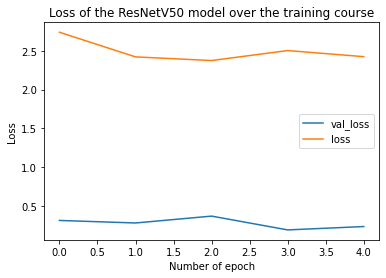

In [ ]:
'''
The loss plot is used to evaluate the interpretability of the model.
This plot shows the loss of the model over the course of training
and allows the effectiveness of the model on the learning task to be evaluated.
'''

#Plot loss
val_loss = resnet_train.history['val_loss']
loss = resnet_train.history['loss']

# let's plot the performance curve
plt.figure()
plt.plot(val_loss, label='val_loss')
plt.plot(loss, label = 'loss')
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of the ResNetV50 model over the training course')
plt.show()

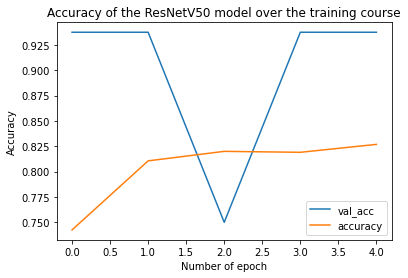

In [ ]:
'''
Accuracy plot is a graphical representation of the accuracy of the model over time
during the training process. It shows how the accuracy of the model changes as the number
of training iterations increases.
'''

#Plot accuracies
val_acc = resnet_train.history['val_accuracy']
acc = resnet_train.history['accuracy']

# let's plot the performance curve
plt.figure()
plt.plot(val_acc, label='val_acc')
plt.plot(acc, label = 'accuracy')
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of the ResNetV50 model over the training course')
plt.legend()
plt.show()

1/1 [==============================] - 3s 3s/step


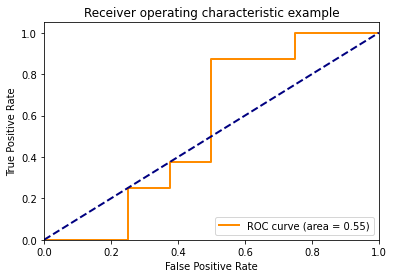

In [ ]:
'''
The ROC curve is a graphical representation of the performance of a model in a binary
classification problem.
It plots the true positive rate (TPR) against the false positive rate (FPR)
'''

#Plot ROC CURVE

batch_size = 32
step_size_test=validation_dataset.n//validation_dataset.batch_size, validation_dataset.reset()
resnet_preds = resnet_model.predict(validation_dataset,verbose=1)


fpr, tpr, _ = roc_curve(validation_dataset.classes, resnet_preds)
roc_auc = roc_auc_score(validation_dataset.classes, resnet_preds)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## **CNN model**

**Build the CNN**

In [ ]:
'''
We build a deep learning model known as CNN model. In order to buld the model the input
shape must be determined, the model is pretrained using the weights feature with imagenet
images. 

Posteriorly we build the model by adding different layers and we optimize it using model.compile, 
we also choose the loss and the metrics we want returned.
'''

i_shape = (224, 224, 3)

cnn_model = keras.models.Sequential([
    #convolutional layer and maxpool layer 1
    keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape = i_shape),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    #convolutional layer and maxpool layer 2
    keras.layers.Conv2D(32, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #convolutional layer and maxpool layer 3
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    #convolutional layer and maxpool layer 4
    keras.layers.Conv2D(128, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(pool_size = (2, 2)),
    #flatten the result
    keras.layers.Flatten(),
    #hidden layer
    keras.layers.Dense(512, activation='relu', activity_regularizer= l1(0.01)),
    #output layer
    keras.layers.Dense(1, activation ='softmax')
])

cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             loss = 'binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 27, 27, 64)      

**Train the model**

In [ ]:
'''
We stalbish callbacks, which tells the fitter when to stop training 
each epoch. In our case, the monitor feature is val_loss and it stops when
there is no decrease after 4 round with no changes.
'''

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=3,
                                            restore_best_weights=True)

cnn_train = cnn_model.fit(train_dataset, 
                          steps_per_epoch = 100,
                          epochs=5, 
                          validation_data=validation_dataset,
                          callbacks= callback, 
                          batch_size = 32)

Epoch 1/5
100/100 [==============================] - 265s 3s/step - loss: 0.5933 - accuracy: 0.7319 - val_loss: 0.8769 - val_accuracy: 0.5000
Epoch 2/5
100/100 [==============================] - 252s 3s/step - loss: 0.4661 - accuracy: 0.7362 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 3/5
100/100 [==============================] - 262s 3s/step - loss: 0.4387 - accuracy: 0.7334 - val_loss: 0.6746 - val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 253s 3s/step - loss: 0.4155 - accuracy: 0.7416 - val_loss: 0.5933 - val_accuracy: 0.5000
Epoch 5/5
100/100 [==============================] - 263s 3s/step - loss: 0.3936 - accuracy: 0.7434 - val_loss: 0.6868 - val_accuracy: 0.5000


In [ ]:
'''
Posteriorly, we save the model in our drive
'''
cnn_model.save('/content/drive/MyDrive/cnn_model.h5')

**Evaluating the performance of CNN**

In [ ]:
'''
In order to evaluate the model we use the test dataset, we check the
model's accuracy.

The accuracy is a measure of the model's ability to correctly classify 
the samples in the training set.
'''

cnn_test_accu = cnn_model.evaluate(test_dataset)
print('The testing accuracy is :', cnn_test_accu[1]*100, '%')

20/20 [==============================] - 19s 966ms/step - loss: 0.7006 - accuracy: 0.6250
The testing accuracy is : 62.5 %


**Some plots for the model**

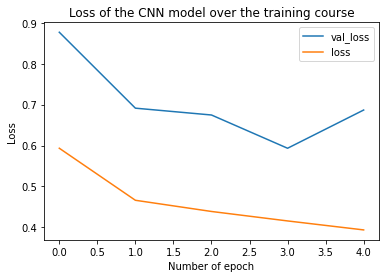

In [ ]:
'''
The loss plot is used to evaluate the interpretability of the model.
This plot shows the loss of the model over the course of training
and allows the effectiveness of the model on the learning task to be evaluated.
'''

val_loss = cnn_train.history['val_loss']
loss = cnn_train.history['loss']

# let's plot the performance curve
plt.figure()
plt.plot(val_loss, label='val_loss')
plt.plot(loss, label = 'loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of the CNN model over the training course')
plt.legend()
plt.show()

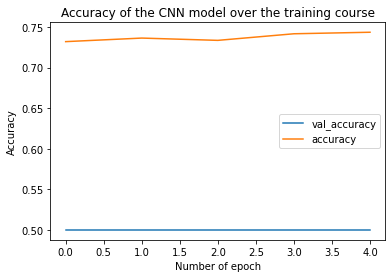

In [ ]:
'''
Accuracy plot is a graphical representation of the accuracy of the model over time
during the training process. It shows how the accuracy of the model changes as the number
of training iterations increases.
'''

#Plot accuracies
val_acc = cnn_train.history['val_accuracy']
acc = cnn_train.history['accuracy']

# let's plot the performance curve
plt.figure()
plt.plot(val_acc, label='val_accuracy')
plt.plot(acc, label = 'accuracy')
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of the CNN model over the training course')
plt.show()

1/1 [==============================] - 1s 738ms/step


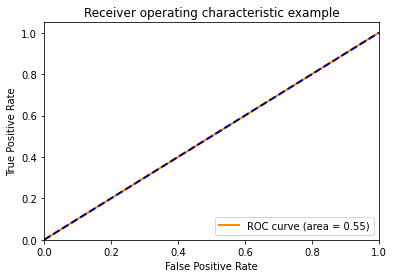

In [ ]:
'''
The ROC curve is a graphical representation of the performance of a model in a binary
classification problem.
It plots the true positive rate (TPR) against the false positive rate (FPR)
'''

#Plot ROC CURVE

batch_size = 32
step_size_test=validation_dataset.n//validation_dataset.batch_size, validation_dataset.reset()
cnn_preds = cnn_model.predict(validation_dataset,verbose=1)

fpr, tpr, _ = roc_curve(validation_dataset.classes, cnn_preds)
roc_auc = roc_auc_score(validation_dataset.classes, resnet_preds)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## **InceptionV3 model**

**Build the InceptionV3 model**

In [ ]:
'''
We build a deep learning model known as InceptionV3 model. In order to buld the model the input
shape must be determined, the model is pretrained using the weights feature with imagenet
images. 

Posteriorly we build the model by adding different layers and we optimize it using model.compile, 
we also choose the loss and the metrics we want returned.
'''

i_shape = (224, 224, 3)

V3= InceptionV3(input_shape = i_shape, 
                       include_top = False, 
                       weights='imagenet')

for layer in V3.layers:
  layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
x = keras.layers.Flatten()(V3.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x= keras.layers.Dropout(0.2)(x)
x= keras.layers.Dense(1, activation='sigmoid')(x)

V3_model = tf.keras.models.Model(V3.input, x)

V3_model.compile(optimizer = RMSprop(learning_rate = 0.0001),
                 loss = 'binary_crossentropy', 
                 metrics = ['acc'])

In [ ]:
V3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                             

**Train the model**

In [ ]:
'''
We stalbish callbacks, which tells the fitter when to stop training 
each epoch. In our case, the monitor feature is val_loss and it stops when
there is no decrease after 4 round with no changes.
'''

callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=4, 
                                         mode = "min")

V3_train = V3_model.fit(train_dataset,
                        callbacks=callback,
                        validation_data=validation_dataset, 
                        steps_per_epoch=100, 
                        epochs=5, 
                        batch_size = 32)

Epoch 1/5
100/100 [==============================] - 555s 5s/step - loss: 1.4897 - acc: 0.8581 - val_loss: 0.6169 - val_acc: 0.8750
Epoch 2/5
100/100 [==============================] - 545s 5s/step - loss: 0.3442 - acc: 0.9187 - val_loss: 0.8896 - val_acc: 0.7500
Epoch 3/5
100/100 [==============================] - 548s 5s/step - loss: 0.2526 - acc: 0.9359 - val_loss: 0.3513 - val_acc: 0.9375
Epoch 4/5
100/100 [==============================] - 549s 5s/step - loss: 0.2512 - acc: 0.9397 - val_loss: 3.9891 - val_acc: 0.5625
Epoch 5/5
100/100 [==============================] - 552s 6s/step - loss: 0.2076 - acc: 0.9481 - val_loss: 0.4429 - val_acc: 0.9375


In [ ]:
'''
Posteriorly, we save the model in our drive
'''
V3_model.save('/content/drive/MyDrive/V3_model.h5')

**Evaluating the performance of the InceptionV3 model**

In [ ]:
'''
In order to evaluate the model we use the test dataset, we check the
model's accuracy.

The accuracy is a measure of the model's ability to correctly classify 
the samples in the training set.
'''

V3_test_accu = V3_model.evaluate(test_dataset)
print('The testing accuracy is :', V3_test_accu[1]*100, '%')

20/20 [==============================] - 96s 5s/step - loss: 0.8582 - acc: 0.8333
The testing accuracy is : 83.33333134651184 %


**Plots for the model**

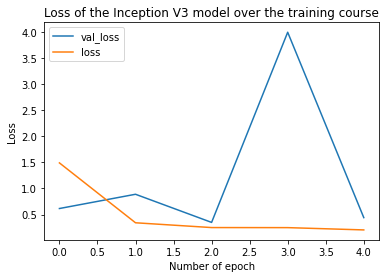

In [ ]:
'''
The loss plot is used to evaluate the interpretability of the model.
This plot shows the loss of the model over the course of training
and allows the effectiveness of the model on the learning task to be evaluated.
'''

val_loss = V3_train.history['val_loss']
loss = V3_train.history['loss']

# let's plot the performance curve
plt.figure()
plt.plot(val_loss, label='val_loss')
plt.plot(loss, label = 'loss')
plt.xlabel('Number of epoch')
plt.ylabel('Loss')
plt.title('Loss of the Inception V3 model over the training course')
plt.legend()
plt.show()

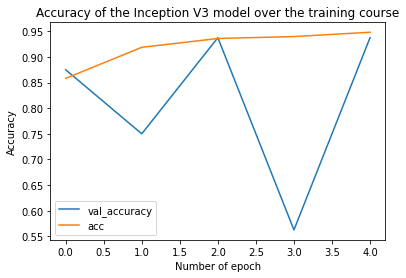

In [ ]:
'''
Accuracy plot is a graphical representation of the accuracy of the model over time
during the training process. It shows how the accuracy of the model changes as the number
of training iterations increases.
'''

#Plot accuracies
val_acc = V3_train.history['val_acc']
acc = V3_train.history['acc']

# let's plot the performance curve
plt.figure()
plt.plot(val_acc, label='val_accuracy')
plt.plot(acc, label = 'acc')
plt.legend()
plt.xlabel('Number of epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy of the Inception V3 model over the training course')
plt.show()

1/1 [==============================] - 3s 3s/step


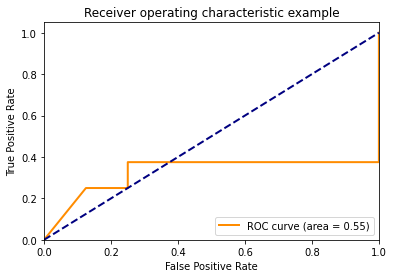

In [ ]:
'''
The ROC curve is a graphical representation of the performance of a model in a binary
classification problem.
It plots the true positive rate (TPR) against the false positive rate (FPR)
'''

batch_size = 32
step_size_test=validation_dataset.n//validation_dataset.batch_size, validation_dataset.reset()
V3_preds = V3_model.predict(validation_dataset,verbose=1)

fpr, tpr, _ = roc_curve(validation_dataset.classes, V3_preds)
roc_auc = roc_auc_score(validation_dataset.classes, resnet_preds)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## **Discussion**

A well-trained **loss graph** should show a decreasing trend in loss as the model is trained, indicating that it is learning and getting better at the learning task. If the loss does not decrease or shows an erratic trend, the model may be overfitted or not working properly.

In addition, comparing the loss graph between different models can help to choose the most appropriate model for a specific task. 

In our case, observing the loss graphs we can see that in the case of the **resnet50 model** the loss of the training set in global computation decreases reaching between 2.74-2.42, although over time it has a somewhat erratic behavior, we can observe how the loss of the validation set remains very small, below 0.4.

In the case of the **cnn model** we can observe that the same thing happens, the loss of the training set in global computation tends to decrease from around 0.6 to below 0.4 and the loss of the validation set also tends to decrease to below 0.6. 

In the **InceptionV3 model**, the training set loss decreases drastically in the first steps and then continues to decrease but in a more stable way, ending up with a loss around 0.2. In the case of the loss of the validation set we can see that the total computation is that it tends to decrease although over time it also increases, finally it goes from being a loss of around 0.8 to a loss below 0.6, passing by a big loss of almost 4.

An **accuracy plot** is a graphical representation of the accuracy of a model over time. The graph shows how the accuracy of the model changes as the number of iterations increases. Accuracy is a measure of the model's ability to correctly classify the samples in the training set.

A well-trained model should show a general increasing trend in accuracy over time, indicating that the model is improving in its ability to correctly classify the samples. If the accuracy stagnates or decreases over time, it may indicate that the model is overfitting the data or that the learning rate is too high.

We use the accuracy plot to compare the performance of different models. For example, a model with a higher accuracy is generally considered a better model than one with a lower accuracy. The accuracy plot can also be used to tune the model by adjusting the hyperparameters, such as the learning rate or the number of training iterations, to achieve the best performance.

In the **resnet50 model** we can observe that the accuracy of the model for the training set increases rapidly at the beginning but at some point the growth stagnates although it continues to increase, we can observe that the highest accuracy occurs in the last Epoch and is 0.8269, while the accuracy for the validation set reaches its maximum value in the first and second Epoch reaching a value of 0.9375.

In the case of the **cnn model** we see that the accuracy obtained for both the training set and the validation set is stagnant throughout the epochs. In the case of the training set the best accuracy is obtained in the last Epoch with a value of 0.7434 and in the validation set it always remains at 0.5.

Finally, in the **InceptionV3 model** we can observe how for the training set the accuracy gradually increases during the Epocs reaching the highest value in the last Epoc with a value of 0.9481 and in the case of the accuracy for the validation set we can observe that it varies, reaching in the last Epoch an accuracy of 0.9375.

The accuracy and loss values for the test sets are found for the resnet50 model at an accuracy of 0.8734 and a loss of 0.3069, the cnn model at an accuracy of 0.625 and a loss of 0.7006 and finally the InceptionV3 model for the test set has a precision of 0.8333 and a loss of 0.8582.

The **ROC curve** is a useful tool for evaluating the performance of a ResNet50 model because it provides a visual representation of the trade-off between TPR and FPR. A model with a high TPR will correctly identify many positive cases, but may also have a high FPR and incorrectly classify many negative cases as positive. On the other hand, a model with a low FPR will correctly identify many negative cases, but may have a low TPR and fail to identify many positive cases. The ROC curve allows us to find the optimal balance between TPR and FPR by choosing the classification threshold that results in the best balance between these two metrics.

The diagonal in a ROC curve plot indicates the performance of the model when it is equivalent to a random model, since the TPR and FPR are equal. That is, the model is randomly classifying observations without taking into account any relevant information.

The area under the curve (AUC) is a commonly used measure to compare the performance of different models. A model that is better than a random model will have an AUC greater than 0.5, while a worse model will have an AUC less than 0.5. A perfect model will have an AUC of 1.0, which means that all positive observations are correctly classified and all negative observations are incorrectly classified.

Therefore, for the **resnet50 model** we can see that the AUC value is low, 0.55, and the line indicating the ROC curve is very close to the diagonal.

In the **cnn model** we can see that it gives us a ROC curve line that is exactly the diagonal and an AUC of 0.55.

In the **InceptionV3 model** we can see that the same happens as for resnet50, the AUC value is  0.55 and the ROC curve is very close to the diagonal.



## **Conclusion**

According to the results obtained for the **resnet50 model** we can assure that the best number of epochs for its analysis would have been 1-2 epochs since this is when the accuracy of the model for the validation data set is the highest and for the training data set it is more or less maintained throughout the epochs after the second epoch.

In the case of the **cnn model**, the accuracy of the validation set remains at 0.5 throughout the epochs, indicating that the model is classifying the observations randomly, without taking into account any relevant information.  An accuracy of 0.5 implies that the model has a similar hit rate and error rate, so its performance is equivalent to that of a random model. This could be because the model is not learning due to lack of relevant information in the training data; it could be due to the lack of parameters but we obtained the same result by increasing layers and epochs and changing the parameters used so we understand that our problem is not due to this, it could be because the training data is unbalanced but, not having obtained this problem with the other two models we discard this option as well and it could be that the model is overfitting to the training data and does not generalize well to new data. So it could be because the cnn model is not a good model for the analysis of our data. That the model has random behavior is corroborated by the ROC curve obtained for it.

In the case of the **InceptionV3 model** we can observe that for the measurement of the model accuracy having used 3 epochs would have been enough to obtain good results since the accuracy of the training set in the following epochs does not increase too much and in the case of the validation set it remains the same. The same is also true for the calculation of the loss with 3 epochs would have been enough to obtain good results.

After all that we have previously commented on the three models generated to adequately classify the images, and taking into account the results obtained, we can say that the **Inception V3 model** is the most suitable of the three to adequately classify the images (as we have already mentioned we have obtained high accuracy in the classification of the training, validation and test images). Some of the advantages of the deep learning models based on Inception include that it is able to learn complex features, also it allows an efficient use of computational resources and also it makes possible to transfer the learning of this pre-trained model to our own data (because we can use the pre-trained weights as a start points). 

So, in conclusion Inception V3 is a robust and reliable model for this problem of image classification that has demostrated good performance for this image classification problem. 

## **Bibliography**

1. Esteva, A., Kuprel, B., Novoa, R.A., Ko, J., Swetter, S.M., Blau, H.M. and Thrun, S., 2017. Dermatologist-level classification of skin cancer with deep neural networks. Nature, 542(7639), pp.115-118.
2. Chen, Y., Wang, L. and Wong, C.K., 2020. Artificial intelligence in ophthalmology: opportunities and challenges. International Journal of Ophthalmology, 13(11), pp.1791-1796.
3. Jia, Y., Kostkova, P., De dreu, M.J., Paton, N.W. and Weber, J., 2020. Artificial intelligence in healthcare: ethical and social implications. The Lancet Digital Health, 2(7), pp.e307-e317.
4. Kermany, D. S. (2018, 22 febrero). Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
5. He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
6. Krizhevsky, A., Sutskever, I. and Hinton, G.E., 2012. ImageNet classification with deep convolutional neural networks. In Advances in neural information processing systems (pp. 1097-1105).
7. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. and Wojna, Z., 2016. Rethinking the inception architecture for computer vision. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).
8. Colab user guide#. Colab User Guide - BigDL latest documentation. (n.d.). Retrieved February 7, 2023, from https://bigdl.readthedocs.io/en/latest/doc/UserGuide/colab.html 
9. Khandelwal, R. (2020, August 21). Input pipeline for images using Keras and tensorflow. Medium. Retrieved February 7, 2023, from https://towardsdatascience.com/input-pipeline-for-images-using-keras-and-tensorflow-c5e107b6d7b9 

10. How to build a simple CNN based image classifier using Keras. Milind Soorya. (2022, June 1). Retrieved February 7, 2023, from https://www.milindsoorya.com/blog/how-to-build-a-simple-cnn-based-image-classifier-using-keras 
11. Team, K. (n.d.). Keras documentation: Introduction to keras for engineers. Keras. Retrieved February 7, 2023, from https://keras.io/getting_started/intro_to_keras_for_engineers/ 
12. Chollet, F. (n.d.). The keras blog. The Keras Blog ATOM. Retrieved February 7, 2023, from https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html 
13. KeepCoding, R. (2022, August 26). Preprocesamiento de Imágenes de Entrada. KeepCoding Tech School. Retrieved February 7, 2023, from https://keepcoding.io/blog/preprocesamiento-imagenes-entrada/ 
14. Phan, B. (2020, July 6). 10 minutes to building a CNN binary image classifier in tensorflow. Medium. Retrieved February 7, 2023, from https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa 